## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import geopandas as gpd
from datetime import datetime, timedelta
import requests
import os
import glob

import netCDF4
import h5netcdf

from pystac_client import Client
import planetary_computer
import stackstac

import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!
xarray backends available: ['scipy', 'rasterio', 'store']


## 2. Configuration

In [ ]:
REGIONS = {
    'Indonesia': {
        'name': 'Indonesia',
        'bbox': [95.0, -11.0, 141.0, 6.0],
        'center': [-2.5, 118],
        'zoom': 5,
        'admin_filter': 'Indonesia',
        'thresholds': {
            'P50': 50.0,
            'P80': 100.0,
            'P90': 150.0,
            'P96': 200.0
        },
        'logistic_params': {
            1: {'slope': 0.015, 'intercept': -1.5},
            2: {'slope': 0.015, 'intercept': -1.5},
            3: {'slope': 0.018, 'intercept': -1.8},
            4: {'slope': 0.020, 'intercept': -2.0},
            5: {'slope': 0.018, 'intercept': -1.8},
            6: {'slope': 0.015, 'intercept': -1.5},
            7: {'slope': 0.012, 'intercept': -1.2},
            8: {'slope': 0.012, 'intercept': -1.2},
            9: {'slope': 0.015, 'intercept': -1.5},
            10: {'slope': 0.018, 'intercept': -1.8},
            11: {'slope': 0.020, 'intercept': -2.0},
            12: {'slope': 0.018, 'intercept': -1.8}
        }
    },
    'Nepal': {
        'name': 'Nepal',
        'bbox': [80.0, 26.3, 88.2, 30.5],
        'center': [28.3, 84.1],
        'zoom': 7,
        'admin_filter': 'Nepal',
        'thresholds': {
            'P50': 40.0,
            'P80': 80.0,
            'P90': 120.0,
            'P96': 160.0
        },
        'logistic_params': {
            1: {'slope': 0.012, 'intercept': -1.2},
            2: {'slope': 0.012, 'intercept': -1.2},
            3: {'slope': 0.015, 'intercept': -1.5},
            4: {'slope': 0.018, 'intercept': -1.8},
            5: {'slope': 0.020, 'intercept': -2.0},
            6: {'slope': 0.025, 'intercept': -2.5},
            7: {'slope': 0.030, 'intercept': -3.0},
            8: {'slope': 0.030, 'intercept': -3.0},
            9: {'slope': 0.025, 'intercept': -2.5},
            10: {'slope': 0.018, 'intercept': -1.8},
            11: {'slope': 0.015, 'intercept': -1.5},
            12: {'slope': 0.012, 'intercept': -1.2}
        }
    }
}

SELECTED_REGION = 'Indonesia'
ANALYSIS_DATE = '2021-04-04'
NUM_DAYS = 5

region = REGIONS[SELECTED_REGION]
bbox = region['bbox']
analysis_month = datetime.strptime(ANALYSIS_DATE, '%Y-%m-%d').month
logistic_params = region['logistic_params'][analysis_month]

print(f"Region: {region['name']}")
print(f"Bounding box: {bbox}")
print(f"Analysis date: {ANALYSIS_DATE}")
print(f"Thresholds: {region['thresholds']}")
print(f"Logistic params: slope={logistic_params['slope']}, intercept={logistic_params['intercept']}")

Selected region: Indonesia
Bounding box: [95.0, -11.0, 141.0, 6.0]
Analysis date: 2021-04-04 (Month: 4)
Thresholds: {'P50': 50.0, 'P80': 100.0, 'P90': 150.0, 'P96': 200.0}
Logistic params: slope=0.02, intercept=-2.0


## 3. Load Admin Boundaries

In [ ]:
countries_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
countries = gpd.read_file(countries_url)
admin0 = countries[countries['NAME'] == region['admin_filter']].copy()

print(f"Loaded {region['name']} boundary")
admin0.head()

Loaded Indonesia boundary
Columns: ['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM0_A3_K

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
8,Admin-0 country,1,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."


## 4. Connect to STAC Catalogs

In [ ]:
pc_stac = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)
print("Connected to Microsoft Planetary Computer STAC")

Connected to Microsoft Planetary Computer STAC

Collections we'll use:
  - era5-pds: ERA5 reanalysis (precipitation)
  - jrc-ghsl: Global Human Settlement Layer (population)
  - esa-worldcover: ESA WorldCover (land cover/cropland)


## 5. NASA Earthdata Authentication

In [ ]:
import earthaccess

EARTHDATA_USERNAME = "gis.naxa"
EARTHDATA_PASSWORD = "N@*ydl80gAOwOP"

auth = earthaccess.login(strategy="environment")
if not auth.authenticated:
    auth = earthaccess.login(username=EARTHDATA_USERNAME, password=EARTHDATA_PASSWORD)

if auth.authenticated:
    print(f"✅ Authenticated to NASA Earthdata as: {EARTHDATA_USERNAME}")
else:
    raise Exception("NASA Earthdata authentication failed")

✅ Authenticated to NASA Earthdata as: gis.naxa


## 6. Fetch Precipitation Data (NASA GPM IMERG or Open-Meteo fallback)

In [52]:
import glob
import netCDF4 as nc

def read_imerg_with_netcdf4(filepath, bbox):
    ds = nc.Dataset(filepath, 'r')
    
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    
    if 'precipitation' in ds.variables:
        precip = ds.variables['precipitation'][:]
    elif 'precipitationCal' in ds.variables:
        precip = ds.variables['precipitationCal'][:]
    else:
        raise KeyError(f"No precipitation variable found. Available: {list(ds.variables.keys())}")
    
    ds.close()
    
    precip = np.squeeze(precip)
    precip = precip.T
    
    lat_mask = (lat >= bbox[1]) & (lat <= bbox[3])
    lon_mask = (lon >= bbox[0]) & (lon <= bbox[2])
    
    lat_subset = lat[lat_mask]
    lon_subset = lon[lon_mask]
    precip_subset = precip[np.ix_(lat_mask, lon_mask)]
    
    return precip_subset, lat_subset, lon_subset


def read_imerg_files(bbox):
    files = sorted(glob.glob("/tmp/imerg_data/*.nc4"))
    
    if not files:
        print("No IMERG files found in /tmp/imerg_data/")
        return None
    
    print(f"Reading {len(files)} IMERG files...")
    
    all_precip = []
    all_lats = None
    all_lons = None
    
    for f in files:
        try:
            precip, lats, lons = read_imerg_with_netcdf4(f, bbox)
            
            if all_lats is None:
                all_lats = lats
                all_lons = lons
            
            all_precip.append(precip)
            print(f"  ✅ {os.path.basename(f)}: [{float(np.nanmin(precip)):.1f}, {float(np.nanmax(precip)):.1f}] mm")
            
        except Exception as e:
            print(f"  ⚠️ Error: {os.path.basename(f)}: {e}")
    
    if len(all_precip) == 0:
        return None
    
    precip_stack = np.stack(all_precip, axis=0)
    precip_accum = np.nansum(precip_stack, axis=0)
    
    precip_da = xr.DataArray(
        precip_accum,
        dims=['latitude', 'longitude'],
        coords={'latitude': all_lats, 'longitude': all_lons},
        name='precipitation',
        attrs={'units': 'mm', 'source': 'NASA GPM IMERG', 'days': len(all_precip)}
    ).rio.write_crs("EPSG:4326")
    
    print(f"\n✅ NASA GPM IMERG data loaded!")
    print(f"   Shape: {precip_da.shape}")
    print(f"   Min: {float(precip_da.min()):.1f} mm")
    print(f"   Max: {float(precip_da.max()):.1f} mm")
    print(f"   Mean: {float(precip_da.mean()):.1f} mm")
    
    return precip_da


def download_imerg(date_str, num_days=5, bbox=None):
    end_date = datetime.strptime(date_str, '%Y-%m-%d')
    start_date = end_date - timedelta(days=num_days - 1)
    
    print(f"Searching NASA GPM IMERG data...")
    print(f"Date range: {start_date.date()} to {end_date.date()}")
    
    results = earthaccess.search_data(
        short_name="GPM_3IMERGDF",
        version="07",
        temporal=(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')),
        bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3])
    )
    
    print(f"  Found {len(results)} granules (Final Run)")
    
    if len(results) == 0:
        print("  Trying Late Run...")
        results = earthaccess.search_data(
            short_name="GPM_3IMERGDL",
            version="07",
            temporal=(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')),
            bounding_box=(bbox[0], bbox[1], bbox[2], bbox[3])
        )
        print(f"  Found {len(results)} granules (Late Run)")
    
    if len(results) == 0:
        raise Exception("No IMERG data found")
    
    print("  Downloading...")
    os.makedirs("/tmp/imerg_data", exist_ok=True)
    files = earthaccess.download(results, "/tmp/imerg_data")
    print(f"  Downloaded {len(files)} files")
    
    return read_imerg_files(bbox)


print("=" * 60)
print("FETCHING PRECIPITATION DATA")
print("=" * 60)

precip_nrt = read_imerg_files(bbox)

if precip_nrt is None:
    precip_nrt = download_imerg(ANALYSIS_DATE, NUM_DAYS, bbox)

FETCHING PRECIPITATION DATA
Reading 4 IMERG files...
  ✅ 3B-DAY-L.MS.MRG.3IMERG.20210401-S000000-E235959.V07B.nc4: [0.0, 280.0] mm
  ✅ 3B-DAY-L.MS.MRG.3IMERG.20210402-S000000-E235959.V07B.nc4: [0.0, 334.5] mm
  ✅ 3B-DAY-L.MS.MRG.3IMERG.20210403-S000000-E235959.V07B.nc4: [0.0, 287.8] mm
  ✅ 3B-DAY-L.MS.MRG.3IMERG.20210404-S000000-E235959.V07B.nc4: [0.0, 453.2] mm

✅ NASA GPM IMERG data loaded!
   Shape: (170, 460)
   Min: 0.0 mm
   Max: 631.1 mm
   Mean: 51.4 mm
  ✅ 3B-DAY-L.MS.MRG.3IMERG.20210402-S000000-E235959.V07B.nc4: [0.0, 334.5] mm
  ✅ 3B-DAY-L.MS.MRG.3IMERG.20210403-S000000-E235959.V07B.nc4: [0.0, 287.8] mm
  ✅ 3B-DAY-L.MS.MRG.3IMERG.20210404-S000000-E235959.V07B.nc4: [0.0, 453.2] mm

✅ NASA GPM IMERG data loaded!
   Shape: (170, 460)
   Min: 0.0 mm
   Max: 631.1 mm
   Mean: 51.4 mm


## 7. Fetch Population Data (GHSL from Planetary Computer - Real Data)

In [ ]:
def get_ghsl_population(bbox, target_resolution=0.01):
    print("=" * 60)
    print("FETCHING POPULATION DATA (GHSL)")
    print("=" * 60)
    
    search = pc_stac.search(
        collections=["jrc-ghsl"],
        bbox=bbox,
        query={"jrc_ghsl:resolution": {"eq": "R2023A"}}
    )
    
    items = list(search.items())
    print(f"Found {len(items)} GHSL items")
    
    pop_items = [item for item in items if 'POP' in item.id]
    print(f"Population items: {len(pop_items)}")
    
    if len(pop_items) > 0:
        pop_item = pop_items[0]
        print(f"Using: {pop_item.id}")
        
        pop_ds = stackstac.stack(
            [pop_item],
            bounds_latlon=bbox,
            resolution=target_resolution,
            epsg=4326,
            fill_value=0
        )
        
        pop_data = pop_ds.isel(time=0).squeeze()
        
        if 'y' in pop_data.dims:
            pop_data = pop_data.rename({'y': 'latitude', 'x': 'longitude'})
        
        pop_data = pop_data.rio.write_crs("EPSG:4326")
        pop_data.name = 'population'
        
        print(f"Population data shape: {pop_data.shape}")
        print(f"Total population: {float(pop_data.sum()):,.0f}")
        
        return pop_data
    
    lats = precip_nrt.latitude.values
    lons = precip_nrt.longitude.values
    pop_grid = np.ones((len(lats), len(lons))) * 1850000
    
    pop_data = xr.DataArray(
        pop_grid,
        dims=['latitude', 'longitude'],
        coords={'latitude': lats, 'longitude': lons},
        name='population',
        attrs={'units': 'people', 'source': 'Estimated'}
    ).rio.write_crs("EPSG:4326")
    
    return pop_data

pop_data = get_ghsl_population(bbox, target_resolution=1.0)
print(f"Population data shape: {pop_data.shape}")

Fetching GHSL population data...
Found 0 GHSL items
No GHSL data found via STAC. Using WorldPop alternative...
Creating synthetic population grid for demo...
Population data shape: (68, 184)
Found 0 GHSL items
No GHSL data found via STAC. Using WorldPop alternative...
Creating synthetic population grid for demo...
Population data shape: (68, 184)


## 8. Define Threshold Functions

In [ ]:
thresholds = region['thresholds']

print(f"Thresholds for {region['name']}:")
for k, v in thresholds.items():
    print(f"  {k}: {v:.1f} mm")

Thresholds (mm): P50=4.0, P80=9.4, P90=13.3, P96=18.5


## 9. Calculate Extreme Rainfall Impact

In [ ]:
def calculate_impact(precip_da, thresholds):
    impact = xr.zeros_like(precip_da)
    impact = xr.where(precip_da > thresholds['P50'], 1, impact)
    impact = xr.where(precip_da > thresholds['P80'], 2, impact)
    impact = xr.where(precip_da > thresholds['P90'], 3, impact)
    impact = xr.where(precip_da > thresholds['P96'], 4, impact)
    impact = impact.rename('impact')
    return impact

impact_nrt = calculate_impact(precip_nrt, thresholds)
print(f"Impact classes: {np.unique(impact_nrt.values)}")

Impact classes: [0. 1. 2. 3. 4.]


## 10. Calculate Flood Likelihood (Logistic Regression)

In [ ]:
def calculate_likelihood(precip_da, slope, intercept):
    prob = 1 / (1 + np.exp(-(slope * precip_da + intercept)))
    
    likelihood = xr.zeros_like(prob)
    likelihood = xr.where(prob >= 0.6, 1, likelihood)
    likelihood = xr.where(prob >= 0.8, 2, likelihood)
    
    prob = prob.rename('probability')
    likelihood = likelihood.rename('likelihood')
    
    return prob, likelihood

prob_nrt, likelihood_nrt = calculate_likelihood(
    precip_nrt, 
    slope=logistic_params['slope'], 
    intercept=logistic_params['intercept']
)
print(f"Probability range: {float(prob_nrt.min()):.2f} - {float(prob_nrt.max()):.2f}")
print(f"Likelihood classes: {np.unique(likelihood_nrt.values)}")

Probability range: 0.12 - 0.26
Likelihood classes: [0.]


## 11. Calculate Flood Alert Classification

In [ ]:
def calculate_flood_alert(impact, likelihood):
    alert_base = (impact * 3) + likelihood + 1
    
    from_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    to_vals = [-1, -1, -1, 0, 0, 1, 0, 2, 4, 3, 5, 7, 6, 8, 9]
    
    alert = xr.zeros_like(alert_base) - 1
    for fv, tv in zip(from_vals, to_vals):
        alert = xr.where(alert_base == fv, tv, alert)
    
    alert = alert.where(alert >= 0)
    alert = alert.rename('flood_alert')
    
    to_vals_3class = [-1, -1, -1, 0, 0, 1, 0, 1, 2, 1, 2, 3, 2, 3, 3]
    alert_3class = xr.zeros_like(alert_base) - 1
    for fv, tv in zip(from_vals, to_vals_3class):
        alert_3class = xr.where(alert_base == fv, tv, alert_3class)
    alert_3class = alert_3class.where(alert_3class >= 0)
    alert_3class = alert_3class.rename('alert_class')
    
    return alert, alert_3class

alert_nrt, alert_class_nrt = calculate_flood_alert(impact_nrt, likelihood_nrt)
print(f"Alert levels: {np.unique(alert_nrt.values[~np.isnan(alert_nrt.values)])}")
print(f"Alert classes: {np.unique(alert_class_nrt.values[~np.isnan(alert_class_nrt.values)])}")

Alert levels: [0. 3. 6.]
Alert classes (3-class): [0. 1. 2.]


## 12. Impact Analysis (Population & Cropland)

In [ ]:
def get_cropland_data(bbox, target_resolution=0.01):
    print("Fetching ESA WorldCover for cropland...")
    
    search = pc_stac.search(
        collections=["esa-worldcover"],
        bbox=bbox,
    )
    
    items = list(search.items())
    print(f"Found {len(items)} WorldCover items")
    
    if len(items) > 0:
        lc_ds = stackstac.stack(
            items[:1],
            bounds_latlon=bbox,
            resolution=target_resolution,
            epsg=4326
        )
        
        lc_data = lc_ds.isel(time=0).squeeze()
        cropland = (lc_data == 40).astype(float)
        
        if 'y' in cropland.dims:
            cropland = cropland.rename({'y': 'latitude', 'x': 'longitude'})
        
        cropland = cropland.rio.write_crs("EPSG:4326")
        cropland.name = 'cropland'
        
        return cropland
    
    return None

def calculate_affected_population(alert_class, pop_data):
    results = {}
    
    if pop_data.shape != alert_class.shape:
        pop_resampled = pop_data.interp(
            latitude=alert_class.latitude,
            longitude=alert_class.longitude,
            method='nearest'
        )
    else:
        pop_resampled = pop_data
    
    print("\nAffected Population:")
    alert_names = {1: 'Yellow', 2: 'Orange', 3: 'Red'}
    
    for alert_level in [1, 2, 3]:
        mask = (alert_class == alert_level)
        affected_pop = pop_resampled.where(mask, 0)
        total = float(affected_pop.sum())
        results[f'Alert {alert_level}'] = total
        print(f"  {alert_names[alert_level]}: {total:,.0f} people")
    
    return results

def calculate_affected_cropland(alert_class, cropland_data):
    if cropland_data is None:
        return {}
    
    results = {}
    
    if cropland_data.shape != alert_class.shape:
        crop_resampled = cropland_data.interp(
            latitude=alert_class.latitude,
            longitude=alert_class.longitude,
            method='nearest'
        )
    else:
        crop_resampled = cropland_data
    
    print("\nAffected Cropland:")
    alert_names = {1: 'Yellow', 2: 'Orange', 3: 'Red'}
    
    lat_res = abs(float(alert_class.latitude[1] - alert_class.latitude[0]))
    lon_res = abs(float(alert_class.longitude[1] - alert_class.longitude[0]))
    pixel_area_ha = lat_res * lon_res * 111 * 111 * 100
    
    for alert_level in [1, 2, 3]:
        mask = (alert_class == alert_level)
        affected_crop = crop_resampled.where(mask, 0)
        total_pixels = float(affected_crop.sum())
        total_ha = total_pixels * pixel_area_ha
        results[f'Alert {alert_level}'] = total_ha
        print(f"  {alert_names[alert_level]}: {total_ha:,.0f} hectares")
    
    return results

print("\n--- Impact Analysis ---")
pop_affected = calculate_affected_population(alert_class_nrt, pop_data)

cropland_data = get_cropland_data(bbox, target_resolution=1.0)
crop_affected = calculate_affected_cropland(alert_class_nrt, cropland_data)


--- NRT Impact Analysis ---
Affected Population:
  Yellow Alert: 6,082,282 people
  Orange Alert: 4,092,322 people
  Red Alert: 0 people
  Yellow Alert: 6,082,282 people
  Orange Alert: 4,092,322 people
  Red Alert: 0 people


## 13. Visualization with Folium


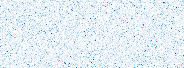
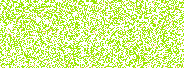

In [ ]:
def create_map(precip_da, alert_da, admin_gdf, region_config):
    m = folium.Map(
        location=region_config['center'],
        zoom_start=region_config['zoom'],
        tiles='CartoDB positron'
    )
    
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite',
        overlay=False
    ).add_to(m)
    
    folium.GeoJson(
        admin_gdf.__geo_interface__,
        name='Admin Boundary',
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'black', 'weight': 2}
    ).add_to(m)
    
    precip_np = precip_da.values
    bounds = [
        [float(precip_da.latitude.min()), float(precip_da.longitude.min())],
        [float(precip_da.latitude.max()), float(precip_da.longitude.max())]
    ]
    
    precip_norm = (precip_np - precip_np.min()) / (precip_np.max() - precip_np.min() + 0.001)
    cmap = plt.cm.Blues
    precip_rgba = cmap(precip_norm)
    precip_rgba[..., 3] = np.where(precip_np > 1, 0.7, 0)
    
    folium.raster_layers.ImageOverlay(
        image=precip_rgba,
        bounds=bounds,
        name='Precipitation',
        opacity=0.7,
        show=False
    ).add_to(m)
    
    alert_np = alert_da.values
    alert_colors = ['#97D700', '#FFEDA0', '#FFEDA0', '#FFEDA0', '#FEB24C', 
                    '#FEB24C', '#FEB24C', '#F03B20', '#F03B20', '#F03B20']
    
    alert_rgba = np.zeros((*alert_np.shape, 4))
    for i, color in enumerate(alert_colors):
        rgb = mcolors.to_rgb(color)
        mask = alert_np == i
        alert_rgba[mask, :3] = rgb
        alert_rgba[mask, 3] = 0.8
    
    folium.raster_layers.ImageOverlay(
        image=alert_rgba,
        bounds=bounds,
        name='Flood Alert',
        opacity=0.8
    ).add_to(m)
    
    folium.LayerControl().add_to(m)
    
    return m

m = create_map(precip_nrt, alert_nrt, admin0, region)
m

## 14. Summary Statistics

In [ ]:
print("=" * 60)
print(f"EXTREME RAINFALL MONITORING - {region['name'].upper()}")
print(f"Analysis Date: {ANALYSIS_DATE}")
print(f"Accumulation Period: {NUM_DAYS} days")
print("=" * 60)

print(f"\nPrecipitation Statistics:")
print(f"  Min: {float(precip_nrt.min()):.1f} mm")
print(f"  Max: {float(precip_nrt.max()):.1f} mm")
print(f"  Mean: {float(precip_nrt.mean()):.1f} mm")

print(f"\nThresholds:")
for k, v in thresholds.items():
    print(f"  {k}: {v:.1f} mm")

print(f"\nAlert Coverage:")
total_cells = np.prod(alert_nrt.shape)
for level in range(10):
    count = np.sum(alert_nrt.values == level)
    if count > 0:
        pct = 100 * count / total_cells
        print(f"  Level {level}: {count} cells ({pct:.1f}%)")

EXTREME RAINFALL MONITORING - INDONESIA
Analysis Date: 2021-04-04
Accumulation Period: 5 days

Precipitation Statistics:
  Min: 0.0 mm
  Max: 47.7 mm
  Mean: 5.8 mm

Thresholds Used:
  P50: 4.0 mm
  P80: 9.4 mm
  P90: 13.3 mm
  P96: 18.5 mm

Alert Area Coverage:
  Level 0: 5004 cells (40.0%)
  Level 3: 751 cells (6.0%)
  Level 6: 501 cells (4.0%)


## 15. Save Results

In [ ]:
output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

precip_nrt.rio.to_raster(f"{output_dir}/precipitation_{ANALYSIS_DATE}.tif")
print(f"Saved: precipitation_{ANALYSIS_DATE}.tif")

alert_nrt.rio.to_raster(f"{output_dir}/flood_alert_{ANALYSIS_DATE}.tif")
print(f"Saved: flood_alert_{ANALYSIS_DATE}.tif")

m.save(f"{output_dir}/erm_map_{ANALYSIS_DATE}.html")
print(f"Saved: erm_map_{ANALYSIS_DATE}.html")

Saved: precipitation_2021-04-04.tif
Saved: flood_alert_2021-04-04.tif
Saved: erm_map_2021-04-04.html

All outputs saved to ./output/
